In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scprep
import sklearn.manifold
import phate
import codecs
import json
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh
from sklearn.cluster import KMeans

In [16]:
def sbm(N, k, pij, pii, sigma):
    """sbm: Construct a stochastic block model

    Args:
        N (integer): Graph size
        k (integer): Number of clusters
        pij (float): Probability of intercluster edges
        pii (float): probability of intracluster edges

    Returns:
        A (numpy.array): Adjacency Matrix
        gt (numpy.array): Ground truth cluster labels
        coords(numpy.array): plotting coordinates for the sbm
    """
    
    ##### Making gt
    
    # Making a dummy gt array with required elements per cluster
    gt = np.asarray(np.array_split(range(N), k))
    
    # Giving label to each array 
    for i in range(k):
        gt[i] = np.repeat(i, len(gt[i]))
    
    # Merging all sub arrays into one
    gt = np.concatenate(gt)
    
    
    #### Making coords
    
    #Empty co-ordinate vector
    coords = np.empty((N, 2))
    
    # Loop for every cluster
    for i in range(k):
        # Mean of every cluster as on a unit circle
        mean = [np.cos((i*2*np.pi)/k + np.pi/4)*5 + 10,np.sin((i*2*np.pi)/k + np.pi/4)*5 +10]
        #mean = [i+1, 5]
        # sigma to define covariance
        cov = [[sigma, 0], [0, sigma]]
        # counting number of elements for label
        num = np.count_nonzero((gt==i))
        # using multivariate model for co-ord generation
        coords[np.argwhere(gt==i).flatten()] = np.random.multivariate_normal(mean, cov, num)

    ### Making adjacency matrix
    
    # Empty matrix
    A = np.empty((N, N))
    
    #Loop to assign probabilities
    
    return A, gt, coords

In [17]:
N=1600
k=4
pij= 0.2
pii = 1
sigma = 3
A, gt, coords = sbm(N, k, pij, pii, sigma)

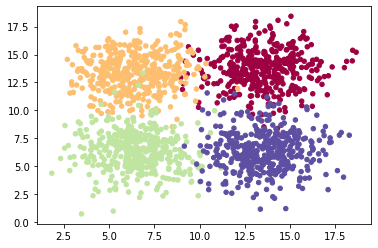

In [18]:
fig = plt.figure()
plt.scatter(coords[:,0],coords[:,1], s= 20, c = gt, cmap= 'Spectral')
plt.show()

In [19]:
X= coords[:,0]
Y= coords[:,1]
coords_swiss = np.array([X*np.cos(X), Y, X*np.sin(X)])
coords_swiss = np.transpose(coords_swiss)

In [20]:
coords_swiss

array([[-3.853106  , 13.88226778, 13.88311667],
       [ 7.44105142, 13.41937493, -9.01055265],
       [ 6.20876005, 12.98440221, 12.17367069],
       ...,
       [ 3.28862346,  6.56614512, 13.50359786],
       [12.60527642,  3.27823971,  1.12539956],
       [12.60415529,  3.30050515,  0.78533344]])

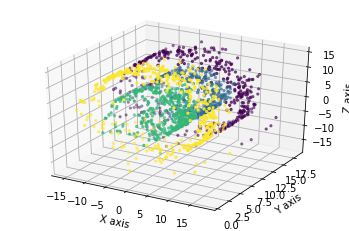

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = coords_swiss[:,0]
y = coords_swiss[:,1]
z = coords_swiss[:,2]
color = gt
ax.scatter(x, y, z, zdir='z', s=5, c=color)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

In [22]:
scaled_dummy_ds = coords_swiss - np.mean(coords_swiss , axis=0)
swiss_roll_labels = gt

In [23]:
Sigma = np.cov(np.transpose(scaled_dummy_ds))

# compute the eigendecomposition
eigenval, eigenvec = np.linalg.eigh(Sigma)

# sort the eigenvectors in order of decreasing eigenvalue
order = np.argsort(eigenval)[::-1] # [::-1] reverses the order of a list
eigenval, eigenvec = eigenval[order], eigenvec[:,order]

data_pca = scaled_dummy_ds @ eigenvec

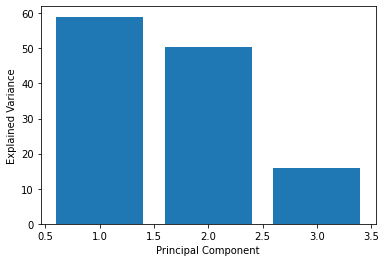

In [24]:
fig = plt.figure()

plt.bar(np.arange(len(eigenval))+1, eigenval)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

plt.show()

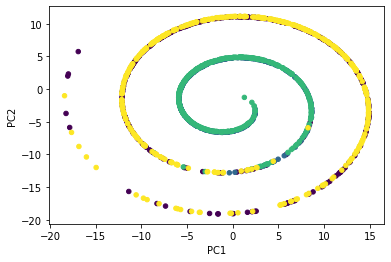

In [25]:
fig = plt.figure()

plt.scatter(data_pca[:,0], data_pca[:,1], c=swiss_roll_labels , s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

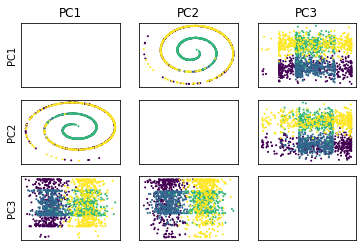

<Figure size 432x288 with 0 Axes>

In [26]:
fig,a =  plt.subplots(3,3)

for i in range(3):
  for j in range(3):
    if i!=j:
      PCi = data_pca[:,i]
      PCj = data_pca[:,j]
      color = range(2005)
      a[i,j].scatter(PCi, PCj, c=swiss_roll_labels, s=1)
      #a[i,j].set_title("PC"+str(i+1)+" vs PC"+str(j+1))
    if i == 0:
      a[i,j].set_title("PC"+str(j+1))
    if j == 0:
      a[i,j].set_ylabel("PC"+str(i+1))
    a[i,j].set_xticks([])
    a[i,j].set_yticks([])


plt.show()
plt.savefig("PCA.png")

In [29]:
tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=200, early_exaggeration=1, method = "exact")
data_tsne = tsne_op.fit_transform(scaled_dummy_ds)

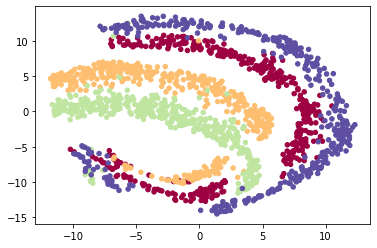

In [30]:
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=swiss_roll_labels, s =20, cmap ='Spectral')
plt.show()

In [31]:
phate_op = phate.PHATE(n_components=2,knn=50)
data_phate = phate_op.fit_transform(scaled_dummy_ds)

Calculating PHATE...
  Running PHATE on 1600 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.12 seconds.
    Calculating affinities...
    Calculated affinities in 0.09 seconds.
  Calculated graph and diffusion operator in 0.22 seconds.
  Calculating optimal t...
    Automatically selected t = 30
  Calculated optimal t in 2.10 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.85 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.42 seconds.
Calculated PHATE in 8.62 seconds.


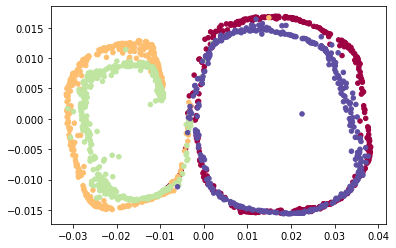

In [32]:
fig = plt.figure()
plt.scatter(data_phate[:,0], data_phate[:,1], c=swiss_roll_labels, s =20, cmap ='Spectral')
plt.show()

In [33]:
def kmeans(X, k, nrep=5, itermax=300):
    """kmeans: cluster data into k partitions

    Args:
        X (n x d np.ndarray): input data, rows = points, cols = dimensions
        k (int): Number of clusters to partition
        nrep (int): Number of repetitions to average for final clustering 
        itermax (int): Number of iterations to perform before terminating
    Returns:
        labels (n x 1 np.ndarray): Cluster labels assigned by kmeans
    """
    ## Initiation of dummy distance total
    Dt = 0
    for nrep in range(nrep):
        # Initialize centroids
        init = kmeans_plusplus(X, k)
        centroids = init
        # dummy centroid vector
        temp_centroid = np.zeros(np.shape(centroids))
        N,d = np.shape(X)
        temp_labels = np.random.randint(k, size=(1, N))
        # dummy labels vector
        temp_labels = temp_labels.flatten()
        
        # Loop to iterate over itermax
        for j in range(itermax):
            # Finding distance of each point from each centroid 
            # and assigning each point to a centroid with the shortest distance to it
            for i in range(N):
                D = np.sqrt(np.sum((centroids[:, np.newaxis, :] - X[i]) ** 2, axis = -1))
                temp_labels[i] = np.argmin(D)
            # Finding the new centroids by taking mean of all points in a given cluster
            for l in range(k):
                mlabels= temp_labels==l
                temp_centroid[l] = np.mean(X[mlabels.flatten()], axis =0)
            centroids = temp_centroid
        
        # Checking for shortest distance for this nrep
        if nrep == 0:
            labels = temp_labels
            # Finding the total distance of each centroid to its cluster and adding all the distances
            for n in range(k):
                Dt += np.sum(np.sqrt(np.sum((X[labels == n, np.newaxis, :] - centroids[n])**2, axis = -1)))
        else:
            Dt_temp = 0
            for n in range(k):
                Dt_temp += np.sum(np.sqrt(np.sum((X[temp_labels == n, np.newaxis, :] - centroids[n])**2, axis = -1)))
            # comparing if the distance of the new centroids is less than the previous least one
            # if yes then assign the new distance and labels as the shortest
            if Dt_temp < Dt:
                Dt = Dt_temp
                labels = temp_labels
    
    return labels


def kmeans_plusplus(X, k):
    """kmeans_plusplus: initialization algorithm for kmeans
    Args:
        X (n x d np.ndarray): input data, rows = points, cols = dimensions
        k (int): Number of clusters to partition

    Returns:
        centroids (k x d np.ndarray): centroids for initializing k-means
    """
    
    # Intiating variables
    N,d = np.shape(X)
    centroids = []
    
    # Random selection of 1 point as a centroid
    x1ind = np.random.randint(N) 
    centroids.append(X[x1ind,:])
    
    # Finding remaining centroids
    for i in range(k - 1):
        # Creating probability distribution
        Dsq = np.sum((X[:, np.newaxis, :] - centroids[i]) ** 2, axis = -1)
        Pxj =  Dsq / np.sum(Dsq)
        # Sampling an xj with probability proportional to p(xj)
        xkind = np.random.choice(N, p= Pxj.flatten())
        centroids.append(X[xkind,:])
    
    centroids = np.array(centroids)
    
    return centroids

def gaussian_kernel(X, kernel_type="gaussian", sigma=3.0, k=5):
    """gaussian_kernel: Build an adjacency matrix for data using a Gaussian kernel
    Args:
        X (N x d np.ndarray): Input data
        kernel_type: "gaussian" or "adaptive". Controls bandwidth
        sigma (float): Scalar kernel bandwidth
        k (integer): nearest neighbor kernel bandwidth
    Returns:
        W (N x N np.ndarray): Weight/adjacency matrix induced from X
    """
    _g = "gaussian"
    _a = "adaptive"

    kernel_type = kernel_type.lower()
    D = squareform(pdist(X))
    if kernel_type == "gaussian":  # gaussian bandwidth checking
        print("fixed bandwidth specified")

        if not all([type(sigma) is float, sigma > 0]):  # [float, positive]
            print("invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth")
            D_find = D + np.eye(np.size(D, 1)) * 1e15
            sigma = np.max(np.min(D_find, 1))
            del D_find
        sigma = np.ones(np.size(D, 1)) * sigma
    elif kernel_type == "adaptive":  # adaptive bandwidth
        print("adaptive bandwidth specified")

        # [integer, positive, less than the total samples]
        if not all([type(k) is int, k > 0, k < np.size(D, 1)]):
            print("invalid adaptive bandwidth, using k=5 as bandwidth")
            k = 5

        knnDST = np.sort(D, axis=1)  # sorted neighbor distances
        sigma = knnDST[:, k]  # k-nn neighbor. 0 is self.
        del knnDST
    else:
        raise ValueError

    W = ((D**2) / sigma[:, np.newaxis]**2).T
    W = np.exp(-1 * (W))
    W = (W + W.T) / 2  # symmetrize
    W = W - np.eye(W.shape[0])  # remove the diagonal
    return W


def L(A, normalized=True):
    """L: compute a graph laplacian

    Args:
        A (N x N np.ndarray): Adjacency matrix of graph
        normalized (bool, optional): Normalized or combinatorial Laplacian

    Returns:
        L (N x N np.ndarray): graph Laplacian
    """
    
    # Creating diagnal matrix
    D = np.diag(np.sum(A, axis=1))
    
    # Creating combinatorial graph Laplacian Lc = D − W
    L = D - A
    
    # normalized graph Laplacian
    if normalized:
        D_inv = np.linalg.inv(D)
        D_inv_half = D_inv**0.5
        L = np.matmul(D_inv_half, (np.matmul(L, D_inv_half)))
        
    return L

def SC(L, k, psi=None, nrep=5, itermax=300, sklearn=False):
    """SC: Perform spectral clustering 
            via the Ng method
    Args:
        L (np.ndarray): Normalized graph Laplacian
        k (integer): number of clusters to compute
        nrep (int): Number of repetitions to average for final clustering
        itermax (int): Number of iterations to perform before terminating
        sklearn (boolean): Flag to use sklearn kmeans to test your algorithm
    Returns:
        labels (N x 1 np.array): Learned cluster labels
    """
    if psi is None:
        # compute the first k elements of the Fourier basis
        e, psi = np.linalg.eigh(L)
        ind = np.argsort(e)
        e = e[ind]
        psi = psi[ind]
        psi_k = psi[:, :k]
        pass
    else:  # just grab the first k eigenvectors
        psi_k = psi[:, :k]
    
    # normalize your eigenvector rows
    psi_norm = psi_k/np.linalg.norm(psi_k, axis=0)
    
    if sklearn == True:
        labels = KMeans(n_clusters=k, n_init=nrep, max_iter=itermax).fit_predict(psi_norm)
        
    
    if sklearn == False:
        labels = kmeans(psi_norm, k, nrep, itermax)
        # your algorithm here
    return labels

In [34]:
label_k = kmeans(scaled_dummy_ds, 4, nrep=5, itermax=300)

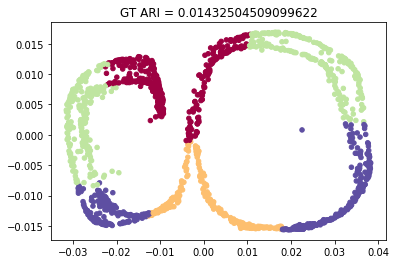

In [35]:
fig = plt.figure()
plt.scatter(data_phate[:,0], data_phate[:,1], c=label_k, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, label_k)))
plt.show()

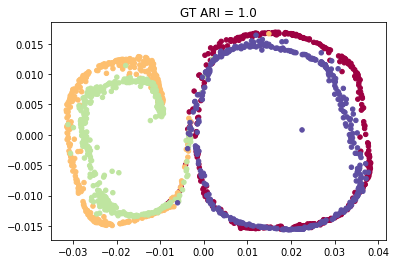

In [36]:
fig = plt.figure()
plt.scatter(data_phate[:,0], data_phate[:,1], c=gt, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, gt)))
plt.show()

In [37]:
W= gaussian_kernel(scaled_dummy_ds, kernel_type="adaptive", k=10)
Ls = L(W)
labels_sc = SC(Ls, k=4, psi=None, nrep=5, itermax=300, sklearn=False)

adaptive bandwidth specified


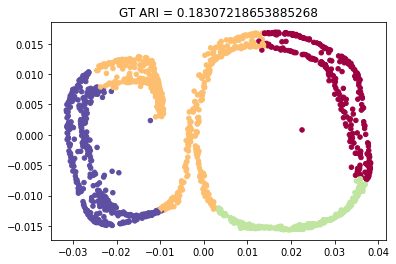

In [38]:
fig = plt.figure()
plt.scatter(data_phate[:,0], data_phate[:,1], c=labels_sc, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, labels_sc)))
plt.show()

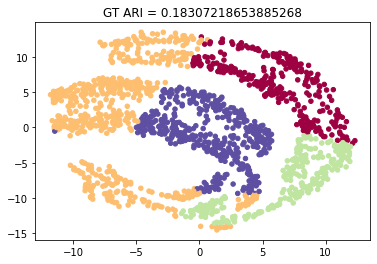

In [39]:
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=labels_sc, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, labels_sc)))
plt.show()

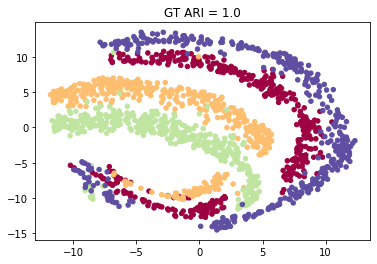

In [40]:
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=gt, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, gt)))
plt.show()

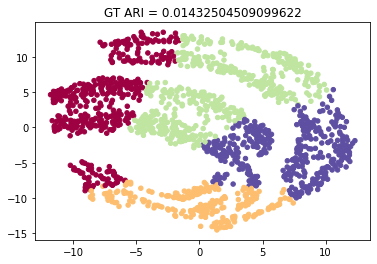

In [41]:
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=label_k, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, label_k)))
plt.show()

In [42]:
import community as community
import networkx as nx
import community as community_louvain

In [43]:
G = nx.from_numpy_array(W)
partion_2 = community_louvain.best_partition(G)

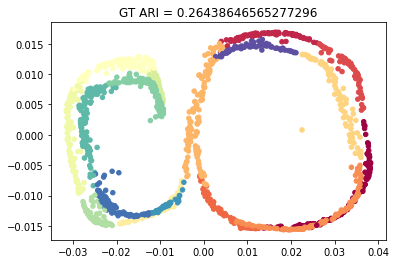

In [45]:
partion_2 = np.array(list(partion_2.items()))[:,1]
fig = plt.figure()
plt.scatter(data_phate[:,0], data_phate[:,1], c=partion_2, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, partion_2)))
plt.show()

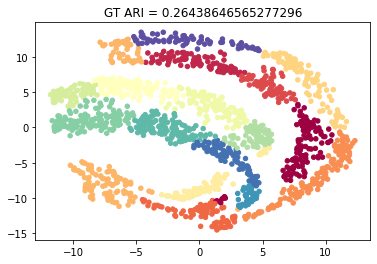

In [47]:

fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=partion_2, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, partion_2)))
plt.show()

In [114]:
length = len(scaled_dummy_ds)
Ws = np.zeros((length,length))
for i in range(length):
    for j in range(i):
        if(i != j):
            if(gt[i] == gt[j]):
                Ws[i,j] = np.random.randint(low=1, high=5, size=1)
                Ws[j,i] = Ws[i,j]
            else:
                Ws[i,j] = np.random.randint(low=1, high=20, size=1)
                Ws[j,i] = Ws[i,j]

In [77]:
def modified_adaptive_gaussian_kernel(X, Ws, k=5):
    D = squareform(pdist(X))
    knnDST = np.sort(D, axis=1)  # sorted neighbor distances
    sigma = knnDST[:, k]  # k-nn neighbor. 0 is self.
    del knnDST
    
    W = ((D**2) / sigma[:, np.newaxis]**2).T
    
    W = (W - np.amin(W))/(np.amax(W) - np.amin(W))
    Ws = (Ws - np.amin(Ws))/(np.amax(Ws) - np.amin(Ws))
    
    W = np.exp(-1 * (0.5*W + 0.5*Ws))
    W = (W + W.T) / 2  # symmetrize
    W = W - np.eye(W.shape[0])  # remove the diagonal
    return W

In [89]:
Wl = modified_adaptive_gaussian_kernel(X = scaled_dummy_ds, Ws = Ws, k =5)

In [90]:
Ls = L(Wl)
labels_gsc = SC(Ls, k=4, psi=None, nrep=5, itermax=300, sklearn=False)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


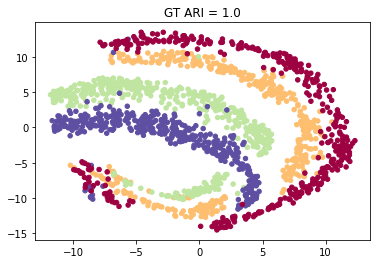

In [91]:
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=labels_gsc, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, labels_gsc)))

plt.show()

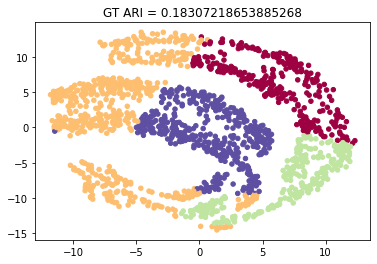

In [83]:
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=labels_sc, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, labels_sc)))
plt.show()

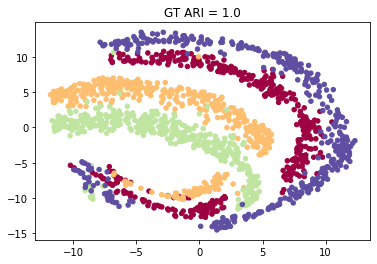

In [82]:
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=gt, s =20, cmap ='Spectral')
plt.title("GT ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, gt)))
plt.show()

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1600 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.08 seconds.
  Calculating diffusion potential...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/graphtools/base.py:553: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated diffusion potential in 0.97 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.64 seconds.
Calculated PHATE in 8.73 seconds.


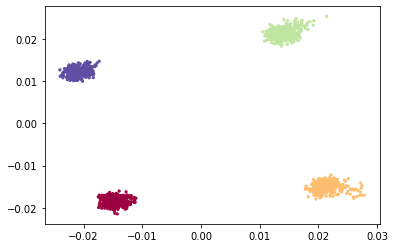

In [85]:
phate_op = phate.PHATE(n_components=2,knn=20, t=7, knn_dist='precomputed_affinity')
data_phate = phate_op.fit_transform(Wl)
fig = plt.figure()
plt.scatter(data_phate[:,0], data_phate[:,1], c=gt, s =5, cmap ='Spectral')
plt.show()

In [97]:
def modified_powered_adaptive_gaussian_kernel(X, Ws, k=5):
    D = squareform(pdist(X))
    knnDST = np.sort(D, axis=1)  # sorted neighbor distances
    sigma = knnDST[:, k]  # k-nn neighbor. 0 is self.
    del knnDST
    
    W = ((D**2) / sigma[:, np.newaxis]**2).T
    W = np.exp(-1 * (W))
    W = (W + W.T) / 2  # symmetrize
    W = W - np.eye(W.shape[0])  # remove the diagonal
    W = np.power(W, Ws)
    return W

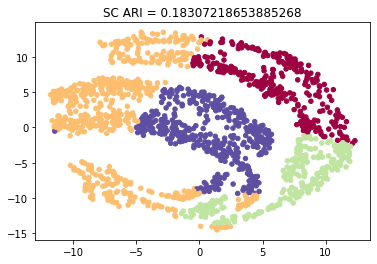

In [100]:
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=labels_sc, s =20, cmap ='Spectral')
plt.title("SC ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, labels_sc)))
plt.show()

In [98]:
Wl = modified_powered_adaptive_gaussian_kernel(X = scaled_dummy_ds, Ws = Ws, k =5)
Ls = L(Wl)
labels_pgsc = SC(Ls, k=4, psi=None, nrep=5, itermax=300, sklearn=False)

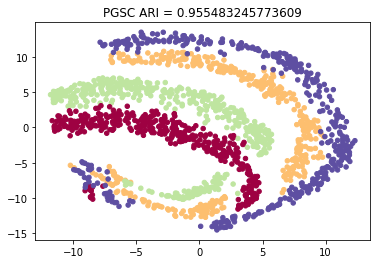

In [99]:
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=labels_pgsc, s =20, cmap ='Spectral')
plt.title("PGSC ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, labels_pgsc)))
plt.show()

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1600 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.28 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.37 seconds.
Calculated PHATE in 5.74 seconds.


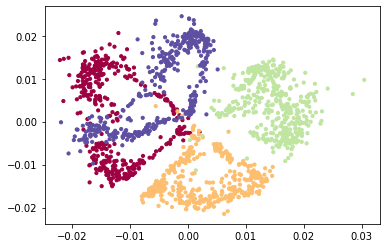

In [106]:
phate_op = phate.PHATE(n_components=2,knn=50, t=3, knn_dist='precomputed_affinity')
data_phate = phate_op.fit_transform(Wl)
fig = plt.figure()
plt.scatter(data_phate[:,0], data_phate[:,1], c=gt, s =10, cmap ='Spectral')
plt.show()

hey
ho
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1600 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 2.00 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.64 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.38 seconds.
Calculated PHATE in 8.20 seconds.
hi
hey
ho
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1600 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 1.90 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.67 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.49 seconds.
Calculated PHATE in 8.15 seconds.
hi
hey


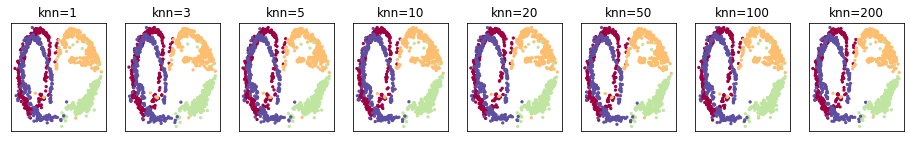

In [109]:
fig, ax = plt.subplots(1, 8, figsize = (16, 2))
knn = [1, 3, 5, 10, 20, 50, 100, 200]

for i, k in enumerate(knn):
    print("hey")
    pt = ax[i]
    phate_op = phate.PHATE(n_components=2,knn=k,knn_dist='precomputed_affinity')
    print("ho")
    Y = phate_op.fit_transform(Wl)
    print("hi")
    pt.set_title("knn=%d" % k)
    pt.scatter(Y[:,0], Y[:,1], c=gt, s =5, cmap ='Spectral')
    pt.set_xticks([])
    pt.set_yticks([])

plt.show()

In [115]:
def modified_alternating_adaptive_gaussian_kernel(X, Ws, k=5):
    D = squareform(pdist(X))
    knnDST = np.sort(D, axis=1)  # sorted neighbor distances
    sigma = knnDST[:, k]  # k-nn neighbor. 0 is self.
    del knnDST
    
    knnDST1 = np.sort(Ws, axis=1)  # sorted neighbor distances
    sigma1 = knnDST1[:, k]  # k-nn neighbor. 0 is self.
    del knnDST1
    
    W = ((D**2) / sigma[:, np.newaxis]**2).T
    W = np.exp(-1 * (W))
    W = (W + W.T) / 2  # symmetrize
    W = W - np.eye(W.shape[0])  # remove the diagonal
    
    Ws = ((Ws**2) / sigma1[:, np.newaxis]**2).T
    Ws = np.exp(-1 * (Ws))
    Ws = (Ws + Ws.T) / 2  # symmetrize
    Ws = Ws - np.eye(Ws.shape[0])
    
    W = np.matmul(W, Ws)
    
    return W

In [116]:
Wl = modified_alternating_adaptive_gaussian_kernel(X = scaled_dummy_ds, Ws = Ws, k =5)


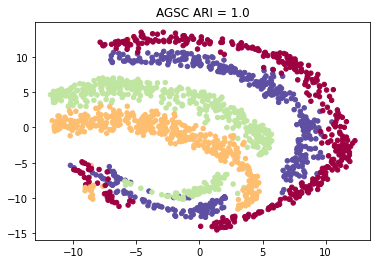

In [117]:
Ls = L(Wl)
labels_agsc = SC(Ls, k=4, psi=None, nrep=5, itermax=300, sklearn=False)
fig = plt.figure()
plt.scatter(data_tsne[:,0], data_tsne[:,1], c=labels_agsc, s =20, cmap ='Spectral')
plt.title("AGSC ARI = " + str(sklearn.metrics.adjusted_rand_score(gt, labels_gsc)))
plt.show()

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1600 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.85 seconds.
Calculated PHATE in 6.00 seconds.


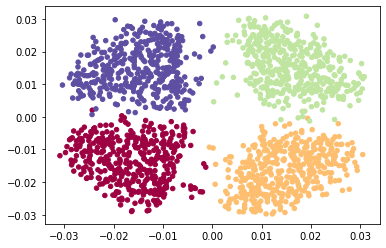

In [118]:
phate_op = phate.PHATE(n_components=2,knn=1, t=1, knn_dist='precomputed_affinity')
data_phate = phate_op.fit_transform(Wl)
fig = plt.figure()
plt.scatter(data_phate[:,0], data_phate[:,1], c=gt, s =20, cmap ='Spectral')
plt.show()